In [1]:
import tensorflow as tf
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import warnings
import tqdm
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading model

In [2]:
# Load graph data
loader = tf.train.import_meta_graph('saved_model/classifier.ckpt.meta')
sess = tf.Session()
loader.restore(sess,'saved_model/classifier.ckpt')
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from saved_model/classifier.ckpt


In [5]:
# Find relevant ops
print([op.name for op in graph.get_operations() if 'output' in op.name or 'features' in op.name])

['network_input/features', 'cnn/output']


In [4]:
# Grab them
x = graph.get_tensor_by_name('network_input/features:0')
y = graph.get_tensor_by_name('cnn/output:0')

# Testing model accuracy (just in case)

In [23]:
test_image = skimage.transform.resize(plt.imread('train/dog.0.jpg'), (128,128,1))
res = sess.run(y, feed_dict={x: [test_image]})
answer = 'cat' if res[0][0]>res[0][1] else 'dog'
print(f'{res[0]} - {answer}')

[0.5252104  0.47478965] - cat


In [6]:
def calculate_accuracy():
    counter = 0
    for i in tqdm.trange(1000):
        animal = 'cat' if i%2==0 else 'dog'
        test_image = skimage.transform.resize(plt.imread(f'train/{animal}.{i}.jpg'), (128,128,1))
        res = sess.run(y, feed_dict={x: [test_image]})
        answer = 'cat' if res[0][0]>res[0][1] else 'dog'
        if answer == animal:
            counter+=1
    return counter
      
counter = calculate_accuracy()
print(f'{counter/10}% accuracy')

100%|██████████████████████████████| 1000/1000 [00:19<00:00, 52.20it/s]


79.5% accuracy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


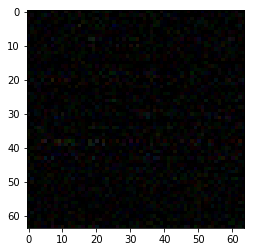

In [70]:
res = sess.run(T('cnn/conv2d_3/kernel'), feed_dict={x: [img]})
plt.imshow(res[0].T)

# Dreaming!

In [7]:
print([op.name for op in graph.get_operations() if 'Conv2D' in op.name])

['training/gradients/cnn/classificator/convolution/conv2d/Conv2D_grad/Const', 'training/gradients/cnn/classificator/convolution/conv2d_1/Conv2D_grad/Const', 'training/gradients/cnn/classificator/convolution/conv2d_2/Conv2D_grad/Const', 'training/gradients/cnn/classificator/convolution/conv2d_3/Conv2D_grad/Const', 'training/gradients/cnn/classificator/convolution/conv2d_4/Conv2D_grad/Const', 'cnn_295/classificator/convolution/conv2d/Conv2D', 'cnn_295/classificator/convolution/conv2d_1/Conv2D', 'cnn_295/classificator/convolution/conv2d_2/Conv2D', 'cnn_295/classificator/convolution/conv2d_3/Conv2D', 'cnn_295/classificator/convolution/conv2d_4/Conv2D', 'cnn_294/classificator/convolution/conv2d/Conv2D', 'cnn_294/classificator/convolution/conv2d_1/Conv2D', 'cnn_294/classificator/convolution/conv2d_2/Conv2D', 'cnn_294/classificator/convolution/conv2d_3/Conv2D', 'cnn_294/classificator/convolution/conv2d_4/Conv2D', 'cnn_293/classificator/convolution/conv2d/Conv2D', 'cnn_293/classificator/convol

(?, 13, 13, 64)
10.451194
10.519797
9.745178
9.958253
10.103227
10.067785
10.312651
9.985912
10.579369
10.378312
9.865069
10.58772
10.341291
9.9065
9.96626
10.260914
9.9987545
10.24344
10.154662
10.289584


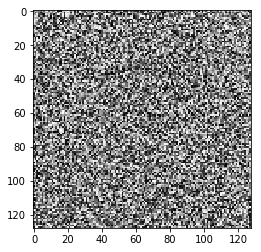

In [60]:
layer = 'cnn_295/classificator/convolution/conv2d_3/Conv2D'
feature = 12

np.random.seed(0)
img_noise = np.random.uniform(size=(1,128,128,1)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    plt.imshow(a[0,:,:,0], cmap='gray')
#     f = BytesIO()
#     PIL.Image.fromarray(a).save(f, fmt)
#     display(Image(data=f.getvalue()))
    
def norm(a, s=0.1):
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    return graph.get_tensor_by_name(f'{layer}:0')

def replace_none_with_zero(l):
    return [0 if i==None else i for i in l] 

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(y, x)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {x:img, T('Placeholder_294'): img})
        
        g /= g.std()+1e-8         
        img += g*step
        print(score)
    showarray(norm(img))
        
    return img

op = T(layer)
print(op.shape)
# plt.imshow(img[0,:,:,0])
img = render_naive(op[:,:,:,feature])

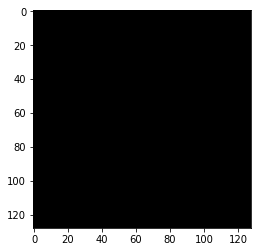

In [61]:
plt.imshow(img_noise[0,:,:,0] - img[0,:,:,0], cmap='gray')
# img.shape